### Preparing the Data

In [1]:
import requests
import json

url = 'https://api.thevirustracker.com/free-api?countryTimeline=EG'

x = requests.post(url) 

#print (x.content)
Data= json.loads(x.content)['timelineitems'][0]
 

In [2]:
import pandas as pd
import numpy as np

data= pd.DataFrame(Data)
data

,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,...,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,stat
new_daily_cases,1,0,0,0,0,0,0,0,0,0,...,698,603,627,676,667,668,659,511,479,ok
new_daily_deaths,0,0,0,0,0,0,0,0,0,0,...,63,51,50,47,41,40,38,40,48,ok
total_cases,1,1,1,1,1,1,1,1,1,1,...,87172,87775,88402,89078,89745,90413,91072,91583,92062,ok
total_recoveries,0,0,0,0,0,0,0,0,0,0,...,21718,21718,21718,21718,21718,21718,21718,21718,21718,ok
total_deaths,0,0,0,0,0,0,0,0,0,0,...,4251,4302,4352,4399,4440,4480,4518,4558,4606,ok


In [3]:
data= pd.DataFrame(Data)
series = data.iloc[0].to_numpy()
series = series[:-1]
series = series.astype('float32')
mean= np.mean(series)
var= np.var(series)
series = ((series - mean)/var)*1000
series

array([-1.7689006 , -1.7720575 , -1.7720575 , -1.7720575 , -1.7720575 ,
       -1.7720575 , -1.7720575 , -1.7720575 , -1.7720575 , -1.7720575 ,
       -1.7720575 , -1.7720575 , -1.7720575 , -1.7720575 , -1.7720575 ,
       -1.7720575 , -1.7689006 , -1.7720575 , -1.7720575 , -1.7720575 ,
       -1.7689006 , -1.7341764 , -1.7720575 , -1.6647277 , -1.753117  ,
       -1.7594304 , -1.7689006 , -1.7499601 , -1.7310196 , -1.6805115 ,
       -1.7689006 , -1.6457871 , -1.6268467 , -1.7720575 , -1.582652  ,
       -1.6805115 , -1.7436467 , -1.6678845 , -1.6489439 , -1.6584141 ,
       -1.6015925 , -1.6489439 , -1.6426305 , -1.6457871 , -1.6678845 ,
       -1.6236899 , -1.6015925 , -1.5542412 , -1.5005763 , -1.3932465 ,
       -1.5037332 , -1.4469113 , -1.3017006 , -1.3679925 , -1.4248141 ,
       -1.3332682 , -1.4721655 , -1.3143276 , -1.3743061 , -1.3774627 ,
       -1.2669762 , -1.28276   , -1.2417221 , -1.2322519 , -1.178587  ,
       -1.4185005 , -1.1754303 , -1.2764465 , -1.2385654 , -1.03

In [4]:
time = data.columns.tolist()
time = time[:-1]


In [5]:
import matplotlib.pyplot as plt


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(20, 8))
plot_series(time, series)

In [6]:
split_time = int(0.95 * series.shape[0])
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 10
batch_size = 5
shuffle_buffer_size = 500

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### The model

In [9]:
import tensorflow as tf
import numpy as np


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#window_size = 64
#batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(next(iter(train_set.take(5))))
# print(x_train.shape)

model = tf.keras.models.Sequential([
  
  tf.keras.layers.Conv1D(filters=50, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),

  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.LSTM(100, return_sequences=True, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.LeakyReLU()
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss="mae",
              optimizer="adam",
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

x = model.evaluate(test_set)


Epoch 1/100
29/29 [==============================] - 10s 348ms/step - loss: 1.6319 - mae: 1.6319
Epoch 2/100
29/29 [==============================] - 1s 37ms/step - loss: 1.6319 - mae: 1.6319
Epoch 3/100
29/29 [==============================] - 1s 37ms/step - loss: 1.6319 - mae: 1.6319
Epoch 4/100
29/29 [==============================] - 1s 43ms/step - loss: 1.6319 - mae: 1.6319
Epoch 5/100
29/29 [==============================] - 1s 42ms/step - loss: 1.6319 - mae: 1.6319
Epoch 6/100
29/29 [==============================] - 1s 41ms/step - loss: 1.6319 - mae: 1.6319
Epoch 7/100
29/29 [==============================] - 1s 37ms/step - loss: 1.6319 - mae: 1.6319
Epoch 8/100
29/29 [==============================] - 1s 37ms/step - loss: 1.6318 - mae: 1.6318
Epoch 9/100
29/29 [==============================] - 1s 37ms/step - loss: 1.6318 - mae: 1.6318
Epoch 10/100
29/29 [==============================] - 1s 45ms/step - loss: 1.6318 - mae: 1.6318
Epoch 11/100
29/29 [===========================

29/29 [==============================] - 1s 51ms/step - loss: 0.8039 - mae: 0.8039
Epoch 87/100
29/29 [==============================] - 1s 39ms/step - loss: 0.9420 - mae: 0.9420
Epoch 88/100
29/29 [==============================] - 1s 40ms/step - loss: 0.7524 - mae: 0.7524
Epoch 89/100
29/29 [==============================] - 1s 40ms/step - loss: 0.8618 - mae: 0.8618
Epoch 90/100
29/29 [==============================] - 2s 55ms/step - loss: 0.6988 - mae: 0.6988
Epoch 91/100
29/29 [==============================] - 1s 51ms/step - loss: 0.7591 - mae: 0.7591
Epoch 92/100
29/29 [==============================] - 1s 36ms/step - loss: 0.7591 - mae: 0.7591
Epoch 93/100
29/29 [==============================] - 1s 44ms/step - loss: 0.6848 - mae: 0.6848
Epoch 94/100
29/29 [==============================] - 1s 48ms/step - loss: 0.7082 - mae: 0.7082
Epoch 95/100
29/29 [==============================] - 1s 39ms/step - loss: 0.6360 - mae: 0.6360
Epoch 96/100
29/29 [==============================] -

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

(5.655877526068171e-09,
 0.0015757960743081156,
 0.5861833098119703,
 1.6816607721406838)

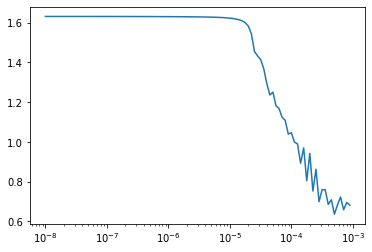

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis()

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

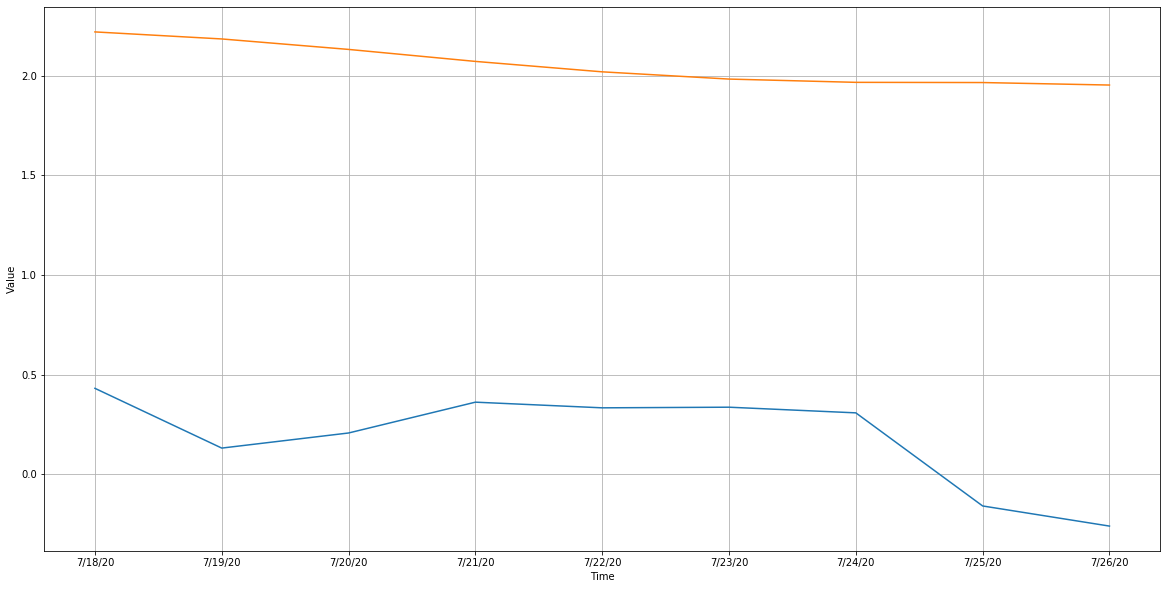

In [12]:
plt.figure(figsize=(20, 10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

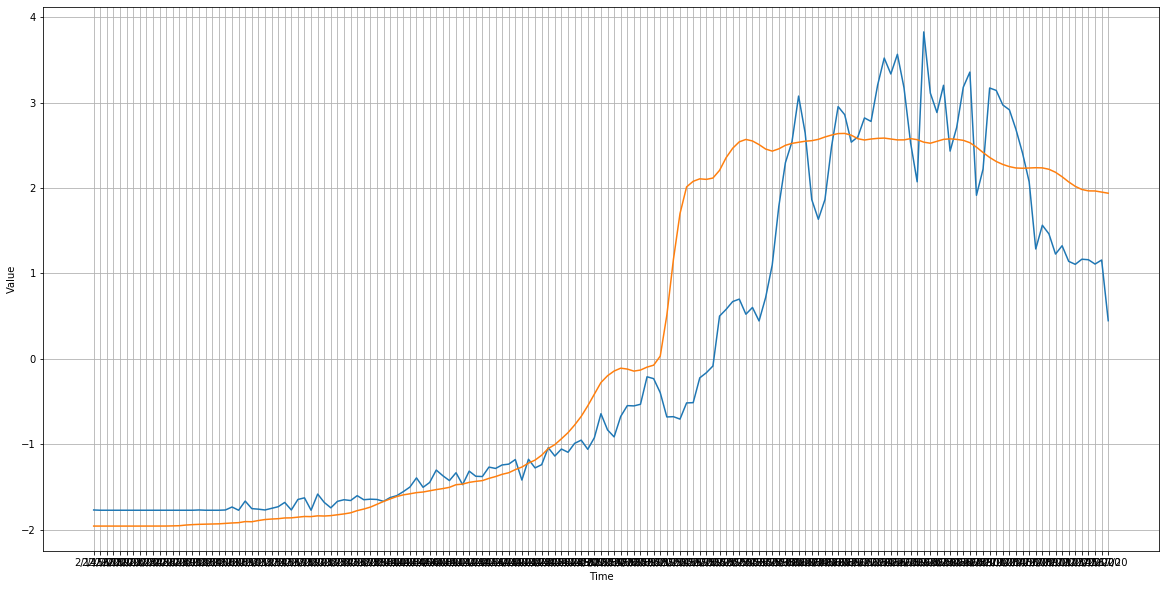

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[ : split_time, -1, 0]

plt.figure(figsize=(20, 10))
plot_series(time_train, x_train)
plot_series(time_train, rnn_forecast)